# Lab 3: Gaussian process regression

### Machine Learning 1, September 2015

* The lab exercises should be made in groups of two, three or four people.
* The deadline is October 25th (Sunday) 23:59.
* Assignment should be sent to Philip Versteeg (p.j.j.p.versteeg@uva.nl). The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: Make sure we can run your notebook / scripts!
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bxp}{\mathbf{x}^{'}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\xm}{\mathbf{x}_m}$
$\newcommand{\xn}{\mathbf{x}_n}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\yi}{\y_i}$
$\newcommand{\thetav}{\mathbf{\theta}}$
$\newcommand{\t}{\mathbf{t}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\tN}{\mathbf{t}_N}$
$\newcommand{\xN}{\mathbf{x}_N}$
$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\CN}{\mathbf{C}_N}$
$\newcommand{\KN}{\mathbf{K}_N}$
$\newcommand{\eyeN}{\mathbf{I}_N}$

# Gaussian process regression

For this Lab we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at http://www.automaticstatistician.com/index.php by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.




### Sinusoidal Data

We will use the same data generating function that we used previously for regression.  You can change sigma/beta, but keep it reasonable.  Definitely play around once you have things working.  Make use of these functions as you wish.

In [11]:
%pylab inline
import pylab as pp

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [95]:
sigma = 0.5
beta  = 1.0 / pow(sigma,2) # this is the beta used in Bishop Eqn. 6.59
N_train = 100
x_train = np.linspace(-1,1,N_train); 
mu_train = np.zeros( N_train )

In [96]:
def true_mean_function( x ):
    return np.sin( 2*pi*(x+1) )

def add_noise( y, sigma ):
    return y + sigma*np.random.randn(len(y))

def generate_t( x, sigma ):
    return add_noise( true_mean_function( x), sigma )

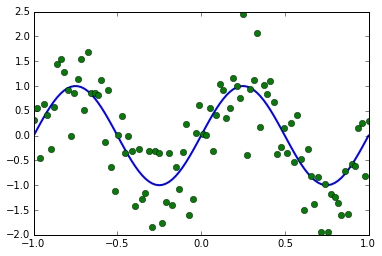

In [97]:
y_train = true_mean_function( x_train )
t_train = add_noise( y_train, sigma )
pp.plot( x_train, y_train, 'b-', lw=2)
pp.plot( x_train, t_train, 'go')

### 1. Sampling from the Gaussian process prior (30 points)

We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 k_n_m( xn, xm, thetas ) (10 points)
To start, implement function "k_n_m( xn, xm, thetas )" that takes scalars $\xn$ and $\xm$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points). 

In [98]:
def k_n_m(xn, xm, thetas):
    return thetas[0]*np.exp(-thetas[1]*0.5*np.linalg.norm(xn-xm)**2)+thetas[2]+thetas[3]*xn* xm
    

#### 1.2 computeK( X1, X2, thetas ) (5 points)
Eqn 6.60 is the marginal distribution of mean ouput of $N$ data vectors: $p(\y) = \mathcal{N}(\zero, \K)$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N$ by $N$ kernel matrix $\K$.  Write a function "computeK( X1, X2, thetas )" that computes the kernel matrix. Hint: use k_n_m as part of an innner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary) (5 points).  

In [99]:
def computeK(X1, X2, thetas):
    K = np.zeros((len(X1), len(X2)) )
    for n in range(len(X1)):
        for m in range(len(X2)):
            K[n][m] = k_n_m(X1[n], X2[m], thetas)
    return K

#### 1.3 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\yi \sim \mathcal{N}(\zero, \K_{\thetav})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\y$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\K$ (the diagonal of $\K$ is the variance of the model uncertainty) (15 points).

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: covariance is not positive-semidefinite.


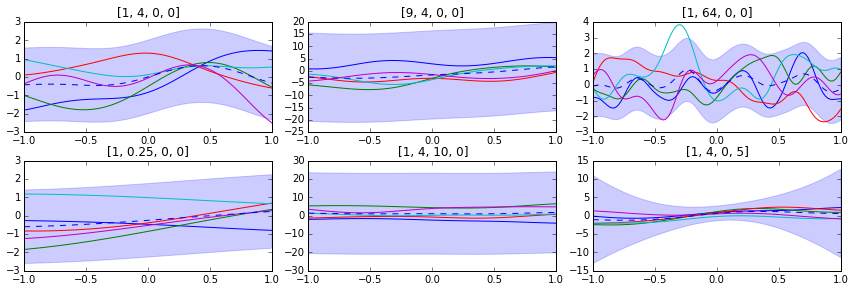

In [125]:
thetas_list = [[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0], [1, 0.25, 0,0],[1,4,10,0],[1,4,0,5]]
plt.subplots(nrows=2, ncols=3,figsize=(12,4))
pp.tight_layout()
for i, thetas in enumerate(thetas_list):
    y_sum = np.zeros(N_train)
    ax = pp.subplot(2,3, i+1)
    ax.set_title(str(thetas))
    for j in range(5):
        K = computeK(x_train, x_train, thetas)
        y = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
        y_sum += y
        pp.plot( x_train, y, lw=1)
    y_ave = y_sum/5
    pp.plot(x_train, y_ave, 'b--')
    std = K.diagonal()
    pp.fill_between( x_train, y_ave+2*std, y_ave-2*std, color='b', alpha=0.2 )

### 2. Predictive distribution (35 points)

So far we have sampled mean functions from the prior.  We can draw actual data $\t$ two ways.  The first way is generatively, by first sampling $\y | \K$, then sampling $\t | \y, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\y$ (the mean draw) and directly sample $\t | \K, \beta$ using Eqn 6.61.    This is the generative process for $\t$.  Note that we have not specified a distribution over inputs $\x$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\x$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\CN$, $\k$, and $c$.  The covariance matrix $CN$ for $\tN$ is $\CN = \KN + \eyeN / \beta$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\k$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function "gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C = None)" that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data.  By having C as an optional parameter, we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\C$, $\k$, and $c$ and the mean and noise functions.  Do not forget: the computeK function computes $\K$, not $\C$! (10 points)

In [126]:
def computeC(X1, X2, thetas, beta):
    C = computeK(X1, X2, thetas)
    C += np.eye(C.shape[0]) * (1.0/beta)
    return C

def gp_predictive_distribution(x_train, t_train, x_test, thetas, beta, C = None):
    if C == None:
        C = computeC(x_train, x_train, thetas, beta)
         
    # create column vector k
    k = np.zeros((N_train, 1))
    N_test = len(x_test)
    mu = np.zeros((N_test, 1))
    sigma = np.zeros((N_test, 1))
    CN = [None] * N_test
    
    # for each test case:
    for i in range(N_test):
        
        # calculate vector k
        for j in range(N_train):
            k[j] = k_n_m(x_train[j], x_test[i], thetas)
        
        c = k_n_m(x_test[i], x_test[i], thetas)+(1.0/beta)
        
        C_inv = np.linalg.inv(C)
        mu[i] = np.dot(k.T, np.dot(C_inv, t_train))
        
        sigma[i] = c - np.dot(k.T, np.dot(C_inv, k))
        
    return mu, sigma

mu, sigma = gp_predictive_distribution(x_train, t_train, [0,1, 3, -3], thetas_list[0], beta)
print mu
print sigma

[[-0.02627629]
 [-0.67664688]
 [ 0.00238294]
 [-0.00167076]]
[[ 0.26065976]
 [ 0.28773758]
 [ 1.24999972]
 [ 1.24999972]]


#### 2.2 gp_log_likelihood(...) (10 points)
Later, to learn the hyperparameters, we will need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\thetav$.  Write a function "gp_log_likelihood( x_train, t_train, theta, C = None, invC = None )", where C and invC can be stored and reused.  (10 points)

In [236]:
# sum log P(t| givens)
#from scipy.stats import multivariate_normal

def multivariate_normal_pdf(x, mu, C, invC):
    return (2*np.pi)**(-0.5*N_train) * np.linalg.det(C)**(-0.5) * np.exp(-0.5 * np.dot((x-mu).T, np.dot(invC, x-mu)))

def gp_log_likelihood(x_train, t_train, thetas, C= None, invC= None):
    try:
        C[0]
    except TypeError:
        C = computeC(x_train, x_train, thetas, beta)
        invC = np.linalg.inv(C)
        
    try:
        invC[0]
    except TypeError:
        invC = np.linalg.inv(C)
    
    lik = multivariate_normal_pdf(x_train, np.zeros(len(x_train)),  C, invC)
    log_lik = np.log(lik)
    return log_lik, C, invC

log_lik, C, invC = gp_log_likelihood(x_train, t_train, thetas)
print log_lik


-33.4663925642


#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the sinuosoidal data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. (10 points)  Try to understand the two types of uncertainty!  If you do not use "gp_plot", please add a fill between for the model and target noise. 

In [214]:
def gp_plot( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta, n):
    # x_test:   the test data
    # y_test:   the true function at x_test
    # mu_test:  predictive mean at x_test
    # var_test: predictive covariance at x_test 
    # t_train:  the training values
    # theta:    the kernel parameters
    # beta:     the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))         # includes all uncertainty, model and target noise 
    std_model = np.sqrt( std_total**2 - 1.0/beta ) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt( 1.0/beta )    # add stddev (note: not the same as full)

    pp.plot( x_test, y_test, 'b', lw=3)
    pp.plot( x_test, mu_test, 'k--', lw=2 )
    
    pp.fill_between( x_test, np.reshape(mu_test+2*std_combo, (n,)), np.reshape(mu_test-2*std_combo, (n,)), color='k', alpha=0.25 )
    pp.fill_between( x_test, np.reshape(mu_test+2*std_model, (n,)), np.reshape(mu_test-2*std_model, (n,)), color='r', alpha=0.25 )
    pp.plot( x_train, t_train, 'ro', ms=3 )

Calculating C
Calculating C
Calculating C
Calculating C
Calculating C
Calculating C


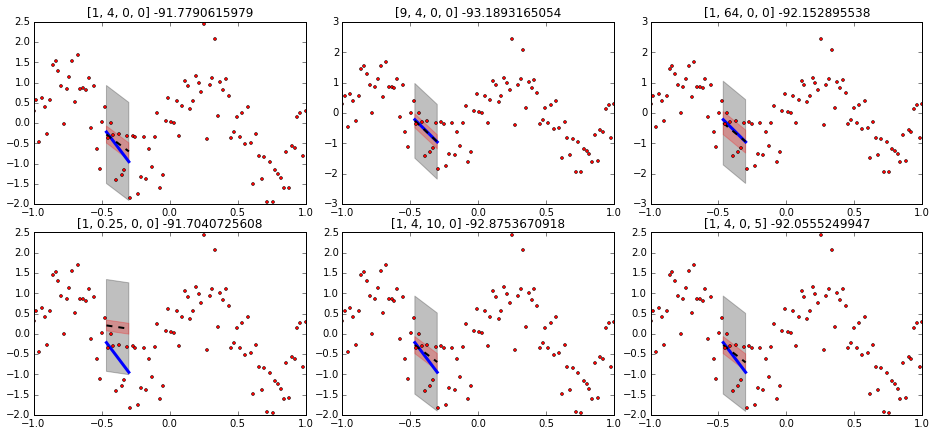

In [230]:
plt.subplots(nrows=2, ncols=3,figsize=(13,6))
pp.tight_layout()
x_test = np.random.uniform(-1,1, 2)
x_test.sort()
y_test = true_mean_function( x_test )
for i, thetas in enumerate(thetas_list):
    ax = pp.subplot(2,3, i+1)
    
    log_lik , _, _ = gp_log_likelihood(x_test, y_test, thetas)
    ax.set_title(str(thetas) + ' ' + str(log_lik))
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, thetas, beta)
    gp_plot(x_test, y_test, mu_test , var_test, x_train, t_train, thetas, beta, 2)

#### 2.4 More ploting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

Calculating C
Calculating C
Calculating C
Calculating C
Calculating C
Calculating C


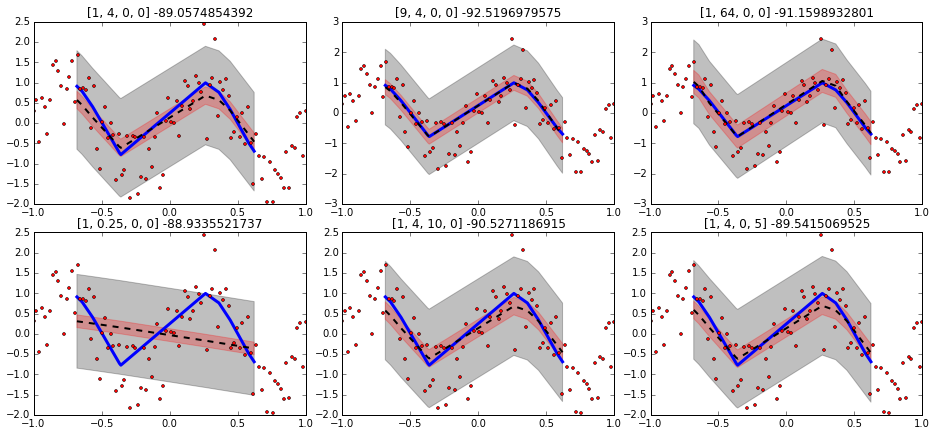

In [231]:
plt.subplots(nrows=2, ncols=3,figsize=(13,6))
pp.tight_layout()
x_test = np.random.uniform(-1,1, 10)
x_test.sort()
y_test = true_mean_function( x_test )
for i, thetas in enumerate(thetas_list):
    ax = pp.subplot(2,3, i+1)
    
    log_lik , _, _ = gp_log_likelihood(x_test, y_test, thetas)
    ax.set_title(str(thetas) + ' ' + str(log_lik))
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, thetas, beta)
    gp_plot(x_test, y_test, mu_test , var_test, x_train, t_train, thetas, beta, 10)

### 3. Learning the hyperparameters (45 points)

Learning the values of the parameter $\thetav$ can be very tricky for Gaussian processes in general, but when the data is univariate like ours, we can visualize the fit and see how plausible it looks.

#### 3.1 Derivatives (5 points)
Maximum likelihood or MAP learning is the most common way of setting the parameters, though a fully Bayesian approach is possible too.  We will look at ML today.  For this, we start with the dervivative of the log-likelihood with respect to the parameters $\thetav$; this is Eqn 6.70.  This, in turn, requires the derivative of the kernel matrix $\CN$ wrt $\thetav$.  This is the matrix of element-wise derivatives of the kernel function.  Write the derivatives for $\theta_0$ to $\theta_3$ for our kernel function (5 points).  

$\frac{\partial k}{\partial \theta_0} = \exp\{-\frac{\theta_1}{2} \|x_n - x_m\|^2\} $

$\frac{\partial k}{\partial \theta_3} = x_n^\top x_m$

#### 3.2 Questions (5 points)
Which parameters in $\thetav$ are unconstrained, that is, where any positive/ negative values are valid? (5 points)

$\theta_0$ and $\theta_3$

#### 3.3 More derivatives (5 points)
For parameters that are constrained to be positive, the usual approach is to use the exponential of the free-parameter in the kernel function, but perform gradient ascent on the unconstrained values.  Consider the case  $\theta_i = \exp( \phi_i)$, where $\phi_i$ is unconstrained.  Write the derivative for $\phi_i$ in terms of the derivatives you already computed (5 points).  Hint: use the chain rule and do not repeat the full derivation.


$\frac{\partial k}{\partial \phi_i} = \frac{\partial k}{\partial \theta_i} \frac{\partial \theta_i}{\theta_i}$

#### 3.4 Grid search (10 points)
Grid-search: for the same training set you have above, perform a small grid search over $\thetav$ (try at least 20 combinations).  Have your grid-search loop or function print out rows of log-likelihood + $\thetav$ sorted by best to worst.  Use the log-likelihood to select the best $\thetav$ and the worst.  Plots both the same way as the subplots above (ie a 1 by 2 subplot of best and worst). (10 points)

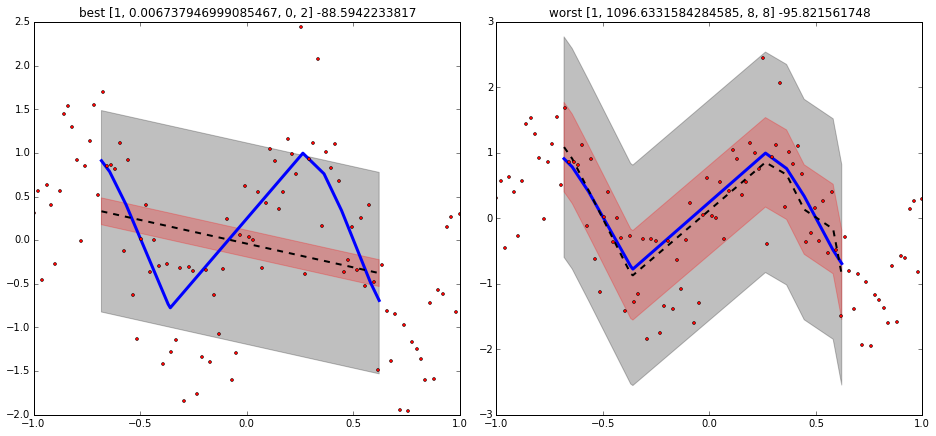

In [289]:
unif = np.random.uniform
import operator
def grid_search():
    plt.subplots(nrows=1, ncols=2,figsize=(13,6))
    pp.tight_layout()
    
    #thetas_list = [[0, 2*x, y, np.exp(y) ] for x in range(5) for y in range(5)]
    thetas_list = [[1, np.exp(x), y,  z] for x in range(-5, 8, 2) for y in range(0, 9, 2) for z in range(0, 9, 2)]
    log_lik_list = []
    data_list = []
    for i, thetas in enumerate(thetas_list):
        log_lik , _, _ = gp_log_likelihood(x_test, y_test, thetas)
        log_lik_list.append(log_lik)
        data_list.append([log_lik, thetas])
#         print '%s\t%s' % (log_lik, thetas)
    sorted_data = sorted(data_list, key=operator.itemgetter(0))
    best_thetas = sorted_data[-1][1]
    worst_thetas = sorted_data[0][1]
    
    ax = pp.subplot(1,2, 1)
    ax.set_title('best ' + str(best_thetas) + ' ' + str(sorted_data[-1][0]))
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, best_thetas, beta)
    gp_plot(x_test, y_test, mu_test , var_test, x_train, t_train, best_thetas, beta, 10)
    
    ax = pp.subplot(1,2, 2)
    ax.set_title('worst ' + str(worst_thetas) + ' ' + str(sorted_data[0][0]))
    mu_test, var_test = gp_predictive_distribution(x_train, t_train, x_test, worst_thetas, beta)
    gp_plot(x_test, y_test, mu_test , var_test, x_train, t_train, worst_thetas, beta, 10)
    
    
grid_search()

#### 3.5 Questions (10 points)
Selecting kernel functions can be somewhat of an art.  There are charateristics of kernel functions that are useful for some data sets, but not others.  Complicating the matter is the ability to combine kernels with different characteristics (long term trends + seasonal fluctuations).  Describe the charactistics of the kernel function we are using in terms of (signal, scale, offsets, etc). You may want to play around with $\thetav$ and see what each parameter does/affects/etc.  (5 points)  Describe why the best parameters work well for the training data and explain why the bad parameter settings perform poorly (in terms of the first part of the question).  (5 points)

* $\theta_0$ sets the scale of the exponential term.
* $\theta_1$ describes the sensitivity to differences in the data points of the exponential term.
* $\theta_2$ determines the linear offset
* $\theta_3$ describes the sensitivity to the inner product of the data points of the linear term.



#### 3.6 Bonus: Implementation (20 points)
Implement gradient-ascent (or descent if you wish) using the combination of a) the log-likelihood objective function and b) the gradients you calculated above.  Run on the training data above and show the log-likehood curve as it learns and a plot of the final model.  Feel free to use available software (eg search for "minimize.py" which uses conjugate gradient descent, or something in scipy).  NB: log-likelihood should be monotonically increasing.  You are encouraged to also search and use "checkgrad".  (20 points)